In [1]:
import numpy as np
print("numpy version:", np.__version__)

import keras
print("keras version:", keras.__version__)

import tensorflow as tf
print("tensorflow version:", tf.__version__)

print("GPU support:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

numpy version: 1.17.5


Using TensorFlow backend.


keras version: 2.2.5
tensorflow version: 1.15.0
GPU support: True


# Um modelo de regressão: Previsão de preços de residências.

Neste exercício será criado um modelo para prever um valor contínuo para a variável de saida. Ao contrário dos exemplos anteriores onde se trabalhou com modelos de classificação, neste caso estaremos diante de um modelo de regressão. 

## O dataset Boston Housing 

O objetivo é prever o preço mediano das residências em um determinado subúrbio de Boston na década de 70 a partir de informações da época tais como taxa de criminalidade, as taxas de IPTU locais, etc...

O dataset tem poucos registros (506 no total, divididos em 404 para o treino e 102 para o teste) e cada uma das 13 variáveis tem uma escala própria, a saber:

1. Taxa de criminalidade per capita.
2. Proporção das zonas residenciais reservadas para lotes de mais de de 25.000 pés quadrados
3. Proporção de acres utilizados para negócios não ligados ao varejo por cidade.
4. Váriavel dummy de proximidade com o rio Charles (= 1 se a área está na margem do rio, 0 caso contrário).
5. Concentração de Óxidos Nítricos (partes por 10 milhões).
6. Número médio de cômodos por residência.
7. Proporção de residências construidas antes de 1940 e habitadas pelos seus proprietários.
8. Distância média ponderada  com cinco centros comerciais da região de Boston.
9. Índice de acessibilidade à estradas radiais.
10. Valor integral da taxa de propriedade por $10,000.
11. Relação aluno-professor por cidade.
12. 1000 * (Bk - 0.63) ** 2 onde Bk é a proporção de pessoas afro-descendentes por cidade.
13. % de pessoas classificadas como baixa renda na população.

A variável target é o valor mediano das residências ocupadas por proprietários em milhares de dólares. Os preços estão na faixa de $\$10,000$ a $\$50,000$ , valores que hoje em dia seriam considerados muito baixos, uma vez que não foram ajustados para a inflação.

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57344/57026 [==============================] - 0s 3us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
train_data[:1]

array([[  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
         91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
         18.72   ]])

In [5]:
train_targets[:7]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3])

In [6]:
test_data.shape

(102, 13)

In [7]:
train_targets[:20]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5])

## Preparação dos dados

Uma vez que os dados tem escalas muito distintas, é recomendável que os mesmos passem por um processo de padronização, por coluna. Cada valor será subtraido da média da coluna e o resultado dividido pelo desvio padrão também da coluna. 

In [0]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Desenvolvimento da rede

A rede deste exemplo terá dois níveis internos com 64 neurons cada. Isto é feito para evitar o overfitting uma vez que a quantidade de pontos disponíveis para treino e teste é muito pequena.

O nível de saida não terá uma função de ativação, para não limitar a faixa de valores passíveis de serem previstos. 

Quanto à função de erro, por ser um problema de previsão será utilizada a MSE (Mean Square Error ou Função de Mínimos Quadrados). 

E por último no caso da métrica de resultado, será utilizado o MAE (Mean Absolute Error). Neste caso como os valores estão em milhares (na variável dependente), um MAE de 0.5 significará que estamos errando em média por \$500.

In [0]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## Treino da rede neural atráves da divisão dos grupos de treino e validação por K-fold 

Quando temos poucos registros na base de dados, costuma-se a cada época refazer a divisão da base entre treino e validação e depois tirar a média dos parâmetros obtidos ao final do treino. Por exemplo com K=4, a cada época divide-se o grupo de treino em quatro sub-grupos e um deles é escolhido por vez para ser o grupo de validação. Executa-se quatro treinos e no final, o valor dos parâmetros para a época de treino é obtido a partir da média dos quatro treinos. 

In [10]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    
    # Preparação dos dados de validação: particionamento de dados k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # Preparação dos dados de validação: dados das demais partições 
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    # construção do modelo keras já implementado
    model = build_model()

    # Treino do modelo 
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=1)
    
    # Avaliação do modelo nos dados de validação
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    print(k, 'finalizou ok')

processing fold # 0







Epoch 1/100





303/303 [==============================] - 9s 30ms/step - loss: 230.4401 - mean_absolute_error: 11.6205
Epoch 2/100
303/303 [==============================] - 1s 3ms/step - loss: 29.4544 - mean_absolute_error: 3.5134
Epoch 3/100
303/303 [==============================] - 1s 3ms/step - loss: 23.2484 - mean_absolute_error: 3.1243
Epoch 4/100
303/303 [==============================] - 1s 3ms/step - loss: 19.3822 - mean_absolute_error: 2.8422
Epoch 5/100
303/303 [==============================] - 1s 3ms/step - loss: 17.6781 - mean_absolute_error: 2.7723
Epoch 6/100
303/303 [==============================] - 1s 3ms/step - loss: 16.7439 - mean_absolute_error: 2.5970
Epoch 7/100
303/303 [==============================] - 1s 3ms/step - loss: 15.4824 - mean_absolute_error: 2.4963
Epoch 8/100
303/303 [==============================] - 1s 3ms/step - loss: 14.4237 - mean_absolute_error: 2.4680
Epoch 9/100
303/303 [==============================] - 1s 2ms

In [0]:
all_scores

[2.2521469569442294, 2.441872516481003, 2.6328625348534915, 2.708972762126734]

In [0]:
np.mean(all_scores)

2.3953995083523267

Como pode ser visto as diferentes rodadas tem escores de validação na faixa de 2.1 a 2.9. Sua média (2.4) será uma métrica bem mais confiável. Neste caso estaremos com uma incerteza de \$ 2.400 \$ em média o que mesmo assim é significativa, pois a faixa de valores para previsão é de  $    \$ 10.000 $ até $ \$ 50.000 $. 

Vamos agora tentar o treino com 500 épocas e armazenar o histórico de evolução do erro durante o treino.

In [0]:
from keras import backend as K

# Limpeza dos dados da sessão associada
K.clear_session()
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)

    # Dados de validação - subgrupo k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Dados de treino - demais subgrupos
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Construção do modelo (já compilado)
    model = build_model()

    # Treino do modelo
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    print(k, 'finished ok')

processing fold # 0
4 finished ok
processing fold # 1
4 finished ok
processing fold # 2
4 finished ok
processing fold # 3
4 finished ok


Calculando a média para todas as subdivisões k, dos escores de MAE por época e apresentando o resultado em forma gráfica, teremos: 

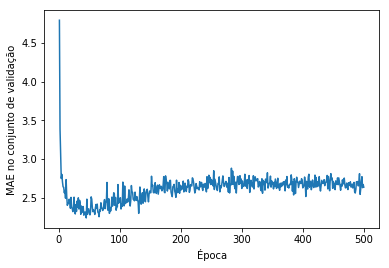

In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Época')
plt.ylabel('MAE no conjunto de validação')
plt.show()

Retirando as 10 primeiras épocas onde o valor de erro é relativamente alto e substituindo cada ponto remanescente por uma média móvel exponencial obtemos o resultado gráfico apresentado a seguir. Nele pode-se perceber que não existe uma melhoria significativa após a época 80. A partir deste momento o sistema começa a apresentar sobreajuste. 


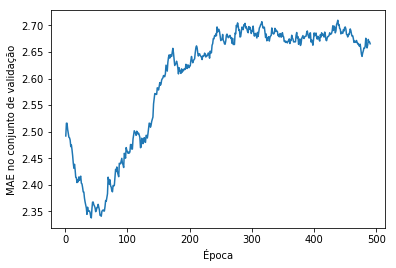

In [0]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Época')
plt.ylabel('MAE no conjunto de validação')
plt.show()


Depois de ajustar o número de épocas de treino pode-se proceder com outros ajustes tais como o número de camadas e a quantidade de neurons em cada camada. Uma vez escolhido o melhor conjunto de hiperparâmetros pode-se criar um modelo definitivo que seria então colocado em produção. Mesmo assim estamos ainda distantes do valor médio correto por um valor de $ \$2.675$.

In [0]:
# Reinicialização do modelo.
model = build_model()

# Treino do mesmo no conjunto completo de dados.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 723us/step


In [0]:
test_mae_score

2.6750272769553987

## Conclusões:

* A regressão é feita com uma função erro e uma métrica de avaliação distintas da classificação, denominadas MSE (Mean Squared Error) e MAE (Mean Absolut Error) . 
* Quando os valores nos dados de entrada tem faixas muito distintas pode-se proceder com a normalização de cada variável em uma faixa (0 a 1) ou com a padronização por variável. 
* Quando existirem poucos registro é preferível utilizar uma rede com menos níveis e menos neurons por camada. para evitar o sobreajuste.


## Exercícios



1.   Quando queremos utilizar a rede neural para prever valores de uma variável contínua, qual o tipo de função de ativação mais indicado para o nível de saída?
2.   Ainda para o caso da questão anterior, qual a função de erro mais indicada?Por quê? 
3.   A qual tipo de regressão a rede neural pode ser comparada neste caso, linear ou logística? Por que?
4.   Descreva o processo de treino k-fold
5.   Quando deve ser utilizado o processo de treino k-fold?
6.   Como é executada a normalização dos valores de entrada de uma variável?
7.   Como é executada a padronização dos valores de entrada de uma variável?
8.   Tomando por base uma rede neural: sequencial, 3 camadas com [64, 64, 1] neurons, função de ativação `relu`, otimizador: rmsprop, função de erro: mse e métrica de desempenho: 'mae', treino do tipo k-fold com k=4, determine de forma gráfica a quantidade de épocas necessárias para iniciar o overfitting. Defina o início do overfitting a época na qual o erro no conjunto de validação iguala o erro no conjunto de treino. Determine o valor deste erro.
9.   Utilize o modelo treinado no exercício anterior para prever o valor da variável de saida para todos os valores das variáveis de entrada presentes no conjunto de teste. Apresente o resultado em forma gráfica, colocando no eixo y os valores previstos e no eixo x os valores reais da variável de saida. 
10.  Calcule o erro total para as previsões realizadas no exercício anterior.

